# Sensor fusion and LQG control of a mass-spring-damper system

Suppose that we wish to estimate the position of an object attached to a spring. 
There are two sensors on the object: 

1. A lidar measuring distance to a wall (which can be converted to position with respect to the equilibrium position) and 
2. An accelerometer measuring acceleration.

The setup is indicated in the figure below. The Kalman filter is often used 
in the context of sensor fusion and this is exploited in this exercise to merge 
the data from the two sensors.


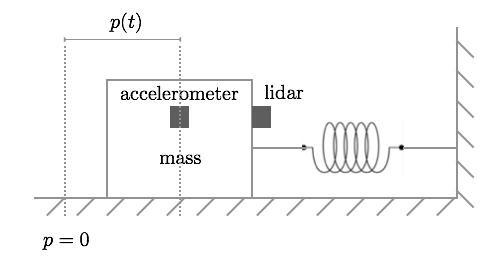

<center>Figure 1: Mass - Spring - Damper System with the two sensors attached</center>

The model of the mass-spring-damper system in the absence of disturbances 
is:

$$\ddot{p}(t)=-\kappa p(t)-b \dot{p}(t),$$

where $p(t)$ is the displacement with respect to the equilibrium position, 
$\kappa=10, b=2$, and where the initial values $p(0), \dot{p}(0)$, do not need 
to be specified here. The sensors are read at a sampling period $\tau=0.05$ 
and the measurements are noisy and characterized by 

$$\begin{array}{l} y_{k} &=p(k \tau)+n_{k} \\ z_{k} &=\ddot{p}(k \tau)+v_{k}, 
\quad k \in \mathbb{N} \cup\{0\} \end{array}$$

where $\left(n_{0}, n_{1}, \ldots\right)$ and $\left(v_{0}, v_{1}, \ldots\right)$, 
are zero-mean Gaussian white noise sequences with variances $N=\mathbb{E}\left[n_{k}^{2}\right], 
V=\mathbb{E}\left[v_{k}^{2}\right]$, for every $k$. Letting $x_{k}:=[p(k \tau) 
\quad \dot{p}(k \tau)]^{\top}$, we can write

$$x_{k+1}=A x_{k}+w_{k}$$

where $A$ is such that $x_{k+1}=A x_{k}$ describes the behavior of $x_{k}$ 
in the absence of disturbances and $\left(w_{0}, w_{1}, \ldots\right)$ is a 
sequence of zero-mean Gaussian white disturbances with covariance $W=$$\mathbb{E}\left[w_{k} 
w_{k}^{\top}\right]$. We assume that $\left(w_{0}, w_{1}, \ldots\right),\left(n_{0}, 
n_{1}, \ldots\right)$ and $\left(v_{0}, v_{1}, \ldots\right)$ are not correlated 
although in general this may not hold. We can assume that 

$$I_{k}:=\left\{y_{\ell}, z_{\ell} | \ell \leq k\right\}$$

is the information set available for estimation at time $k \tau$ for $k \in 
\mathbb{N}$. The goal of this Live Script, is to compute the asymptotic error 
covariance matrix

$$\Theta:=\lim _{k \rightarrow \infty} \mathbb{E}\left[\left(x_{k}-\hat{x}_{k 
| k}\right)\left(x_{k}-\hat{x}_{k | k}\right)^{\top} | I_{k}\right]$$

of the Kalman filter state estimate $\hat{x}_{k | k}:=\mathbb{E}\left[x_{k} 
| I_{k}\right]$. This can be computed by solving a Riccati equation (see (1) 
below). The Matlab function `kalmanmassspring`, computes the asymptotic error 
covariance matrix $\Theta$ for given noise and diturbance covariances in two 
different ways: (i) iterating the Kalman filter for a large number of steps 
and checking that indeed the covariance matrices converge to a stationary value 
($\Theta)$; (ii) calling the `MATLAB` function `kalman` which solves the Riccati 
equation. An example is provided next, where $\Theta$ is illustrated throught 
the elipsoid $\{\Theta^{1/2}x|x^Tx=1\}$.

In [ ]:
import numpy as np
from scipy import signal
import scipy.linalg
import matplotlib.pyplot as plt
from course_functions import dlqr
from course_functions import kalman

In [ ]:
def kalmanmassspring(N,V,W):
    kappa = 10
    b   = 2
    tau = 0.05
    A = np.array([[0,1],[-kappa, -b]])
    Ad = scipy.linalg.expm(A*tau)
    C = np.array([[1, 0],[-kappa, -b]])
    NV = np.array([[N, 0],[0, V]])
    
    #Method 1 iterate time-varying kalman filter
    Theta = [np.zeros((2,2)) for idx in range(1000+1)]
    Theta_ = [np.zeros((2,2)) for idx in range(1000+1)]
    Theta[0] = np.eye(2)
    for k in range(1000):
        Theta_[k+1]= Theta[k]-Theta[k]@C.T@np.linalg.inv(C@Theta[k]@C.T+NV)@C@Theta[k]
        Theta[k+1] = Ad@Theta[k]@Ad.T+W - Ad@Theta[k]@C.T@np.linalg.inv(C@Theta[k]@C.T+NV)@C@Theta[k]@Ad.T
    theta_method1 = Theta_[-1]

    #Method 2 use matlab function
    G = np.eye(2)
    
    L ,theta, E = kalman(Ad, G,C ,W,NV, continuous=False)[:3]
    theta_method2 = theta-theta@C.T@np.linalg.inv(C@theta@C.T+NV)@C@theta
    
    return theta_method1, theta_method2

In [ ]:
def lqgmassspring(Q,R,N,V,W):

    #kalman filter covariance 
    kappa = 10
    b = 2
    tau = 0.05
    A = np.array([[0,1],[-kappa,-b]])
    B = np.array([[0],[1]])
    C = np.array([[1, 0],[-kappa,-b]])
    n = A.shape[0]
    m = B.shape[1]
    p = C.shape[0]
    Ad, Bd = signal.cont2discrete((A, B, C, np.array([[0],[0]])), tau)[:2]
    NV = np.diag([N, V])
    G = np.eye(2)
    L,theta2,E = kalman(Ad,G,C ,W,NV, continuous=False)[:3]
    theta2 = theta2-theta2@C.T@np.linalg.inv(C@theta2@C.T+NV)@C@theta2

    #obtain K and P
    K,P, eigVals = dlqr(Ad,Bd,Q,R)
    K = -K

    #Method 1- analytical cost, formula  trace(Theta*K'*(B'*P*B+R)*K) + trace(P*W)
    cost_method1 = np.trace(theta2@K.T@(Bd.T@P@Bd+R)@K)+np.trace(P@W)
    
    #Method 2 - monte carlo
    sqrtN = np.sqrt(N)
    sqrtV = np.sqrt(V)
    sqrtW = scipy.linalg.sqrtm(W)
    np.random.seed(1)
    nMC = 30
    kend = 10000
    costT = np.zeros((1,nMC))
    for kmc in range(nMC):
        y = np.zeros((p,kend))
        u = np.zeros((1,kend))
        xhat = np.zeros((n,kend))
        x = np.zeros((n,kend+1))
        xhat_1 = np.zeros((n,kend+1))
        cost1 = 0
        for k in range(kend):
            y[:,[k]] = C@x[:,[k]]+np.array([[sqrtN*np.random.randn()],[sqrtV*np.random.randn()]])
            xhat[:,[k]] = xhat_1[:,[k]] + L@(y[:,[k]]-C@xhat_1[:,[k]])
            u[:,[k]] = K@xhat[:,[k]]
            xhat_1[:,[k+1]] = Ad@xhat[:,[k]] + Bd@u[:,[k]]
            x[:,[k+1]] = Ad@x[:,[k]]+Bd@u[:,[k]]+sqrtW@np.random.randn(2,1)
            cost1 = cost1 + x[:,[k]].T@Q@x[:,[k]] + u[:,[k]].T*R*u[:,[k]]
        
        costT[0,kmc] = cost1[0][0]/kend
    
    cost_method2 = np.mean(costT)
    
    return cost_method1, cost_method2

In [ ]:
#Sample input for the sensor fusion
N = 1
V = 1
W = np.eye(2)
# this function computes the asymptotic error covariance matrix using two equivalent methods, the outputs should have very approximate values       
[theta_method1,theta_method2] = kalmanmassspring(N,V,W)

In [ ]:
# plot ellipsoid
f = plt.figure()
ax = plt.gca()
sqrttheta = scipy.linalg.sqrtm(theta_method1)
ang = np.append(np.arange(0,2*np.pi,0.1),2*np.pi)
v = np.zeros((2,len(ang)))
for i in range(len(ang)):
    v[:,[i]] = sqrttheta@np.array([[np.cos(ang[i])],[np.sin(ang[i])]])

ax.plot(v[0,:],v[1,:])
ax.grid(True)
ax.set_xlabel('position')
ax.set_ylabel('velocity')
ax.set_title('Elipse {Theta x| |x|=1}')
ax.axis('equal');

 
# LQG control

Still in the context of Figure 1, suppose that a force $f$ is applied to the 
system and the equation of motion of the system become

$$\ddot{p}(t)=-\kappa p(t)-b \dot{p}(t)+f(t)$$

where again the initial conditions do not need to be specified. 

We can assume that the force input is held constant in the interval $t \in[k 
\tau,(k+1) \tau)$, i.e., $f(t)=u_{k}, t \in[k \tau,(k+1) \tau)$. Then, we can 
obtain 

$$x_{k+1}=A x_{k}+B u_{k}+w_{k},$$

where $A$ and $B$ are such that $x_{k+1}=A x_{k}+B u_{k}$, describes the behavior 
$x_k$ in the absence of disturbances, while the disturbances are as defined 
before. 

In this live script we are interested in computing the optimal average cost

$$\lim _{T \rightarrow \infty} \frac{1}{T} \mathbb{E}\left[\sum_{k=0}^{T-1} 
x_{k}^{\top} Q x_{k}+u_{k}^{\top} R u_{k}\right]$$

of the associated optimal control policy for the control input $u_{k}$ minimizing 
this cost, when the control input $u_{k}$ is allowed to be a function of the 
information set

$$I_{k}:=\left\{y_{\ell}, z_{\ell} | \ell \leq k\right\} \cup\left\{u_{\ell} 
| \ell<k\right\},$$

when $k>0$, and a function of $I_{0}=\left\{y_{0}, z_{0}\right\}$ when $k=0$, 
and where $y_{\ell}, z_{\ell}$ are as the sensor fusion section. The optimal 
policy is

$$u_k = K\hat{x}_{k|k}$$ 

where

$$K = -(R+B^T PB)^{-1}B^TPA$$

and $P$ is the unique positive definite solution to

$$P = A^TPA + Q - A^TPB(R+B^TPB)^{-1}B^TPA$$

and $\hat{x}_{k|k}$is obtained by running the Kalman filter

$$\hat{x}_{k+1|k}=A\hat{x}_{k|k}+Bu_k$$

$$\hat{x}_{k|k} = \hat{x}_{k|k-1}+L(y_k-C\hat{x}_{k|k-1})$$

where

$$L = \Phi C^T(C\Phi C^T+V)^{-1}$$

and $\Phi$is the unique positive definite solution to

$$\Phi = A\Phi A^T-A\Phi C^T(C\Phi C^T+V)^{-1} C\Phi A^T+W=A\underbrace{\Phi 
-\Phi C^T(C\Phi C^T+V)^{-1} C\Phi}_\Theta A^T+W \ \ (1)$$

The average cost for this optimal policy can be theoretically computed as 
is given by

$$\text{trace}(\Theta K^T (B^T P B+R) K)+\text{trace}(P W)$$

The Matlab function `lqgmassspring` computes the optimal average cost, 
which is associated with the optimal control policy, using two methods: (i) 
an analytical expression; (ii) monte carlo simulations with the optimal policy. 
The input parameters for this problem are the same as the ones for the function 
`kalmanmassspring` above, with two extra arguments, the $Q$ matrix and the scalar 
value $R$.

In [ ]:
#Sample input for LQG
N = 1
V = 1
W = np.eye(2)
Q = np.eye(2)
R = 1      
lqg_cost_method1, lqg_cost_method2 = lqgmassspring(Q,R,N,V,W)

In [ ]:
lqg_cost_method1

In [ ]:
lqg_cost_method2